> 初版，没有修正。

In [ ]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[2] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

# 神经网络的数学构建模块

> 本章涵盖：
>* 神经网络的第一个例子
>* 张量和张量运算
>* 神经网络如何通过反向传播和梯度下降进行学习

理解深度学习需要熟悉很多简单的数学概念：张量张量运算微分梯度下降，，，，等等。 我们在本章中的目标是建立您对这些概念的直觉，而不会过于技术化。 特别是，我们将避开数学符号，它会给没有任何数学背景的人带来不必要的障碍，并且没有必要很好地解释事物。 对数学运算最准确、最明确的描述是它的可执行代码。

为了提供足够的背景介绍张量和梯度下降，我们将从一个神经网络的实际例子开始本章。 然后我们将逐点回顾每个引入的新概念。 请记住，这些概念对于您理解后续章节中将出现的实际示例至关重要！

阅读本章后，您将对深度学习背后的数学理论有一个直观的理解，并且您将准备好在第 3 章中开始深入研究 Keras 和 TensorFlow。

## 神经网络初探

让我们看一个使用 Python 库 Keras 学习对手写数字进行分类的神经网络的具体示例。除非您已经有使用 Keras 或类似库的经验，否则您不会立即了解第一个示例的所有内容。没关系。在下一章中，我们将回顾示例中的每个元素并详细解释它们。因此，如果某些步骤对您来说看起来很随意或看起来很神奇，请不要担心！我们必须从某个地方开始。

我们在这里试图解决的问题是将手写数字（28 × 28 像素）的灰度图像分为 10 个类别（0 到 9）。我们将使用 MNIST 数据集，这是机器学习社区中的经典数据集，它的存在时间几乎与该领域本身一样长，并且已经过深入研究。这是一组 60,000 张训练图像和 10,000 张测试图像，由美国国家标准与技术研究所（MNIST 中的 NIST）在 1980 年代组装。您可以将“解决”MNIST 视为深度学习的“Hello World”——这是您验证算法是否按预期工作的方式。当您成为机器学习从业者时，您会看到 MNIST 一遍又一遍地出现在科学论文、博客文章等中。你可以在图 2.1 中看到一些 MNIST 样本。
> 关于类别和标签的注意事项： 在机器学习中，分类问题中的种类称为类别，数据点称为样本。 与特定样本相关联的类是称为标签的样本。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsgzlf8ctjj31em0ag0tj.jpg)

您现在不需要尝试在您的机器上重现此示例。 如果您愿意，您首先需要设置一个深度学习工作区，这将在第 3 章中介绍。

MNIST 数据集以一组四个 NumPy 数组的形式预加载在 Keras 中。

> 清单 2.1 在 Keras 中加载 MNIST 数据集

In [91]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

time: 681 ms (started: 2021-07-17 21:03:32 +08:00)


`train_images` 和 `train_labels` 构成训练集，即模型将学习的数据。 然后将在测试集 `test_images` 和 `test_labels` 上测试模型。 图片被编码为NumPy数组，标签是一个数字数组，范围从0到9。图片和标签一一对应。

让我们看一下训练数据：

In [92]:
train_images.shape

(60000, 28, 28)

time: 1.37 ms (started: 2021-07-17 21:03:33 +08:00)


In [93]:
len(train_labels)

60000

time: 2.68 ms (started: 2021-07-17 21:03:33 +08:00)


In [94]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

time: 2.98 ms (started: 2021-07-17 21:03:33 +08:00)


这是测试数据：

In [95]:
test_images.shape

(10000, 28, 28)

time: 1.73 ms (started: 2021-07-17 21:03:33 +08:00)


In [96]:
len(test_images)

10000

time: 1.52 ms (started: 2021-07-17 21:03:33 +08:00)


In [97]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

time: 1.47 ms (started: 2021-07-17 21:03:33 +08:00)


工作流程如下：首先，我们将向神经网络提供训练数据 `train_images`和`train_labels`。 然后网络将学习关联图像和标签。 最后，我们将要求网络为`test_images`生成预测，我们将验证这些预测是否与`test_labels`中的标签匹配。

让我们构建网络 - 再次记住，您还不需要了解有关此示例的所有内容。

> 清单 2.2 网络架构

In [98]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

time: 5.87 ms (started: 2021-07-17 21:03:33 +08:00)


神经网络的核心构建块是 . 您可以将图层视为图层数据的过滤器：一些数据进入，它以更有用的形式出现。 具体来说，层从输入它们的数据中提取表示——希望这些表示对手头的问题更有意义。 大多数深度学习包括将简单的层链接在一起，这些层将实现一种渐进式数据提取形式。 深度学习模型就像数据处理的筛子，由一系列越来越精细的数据过滤器（层）组成。

在这里，我们的模型由两层的序列组成，它们是密集连接（也称为密集连接）的神经层。 第二层（也是最后一层）是一个 10 路 softmax 分类层，这意味着它将返回一个包含 10 个概率分数（总和为 1）的数组。 每个分数将是当前数字图像属于我们的 10 个数字类别之一的概率。

为了让模型为训练做好准备，我们还需要选择三件事，作为编译步骤的一部分：
* 优化器——模型将根据它看到的训练数据更新自身以提高其性能的机制。
* 损失函数——模型如何能够衡量其在训练数据上的表现，从而能够将自己引导到正确的方向。
* 在训练和测试期间监控的指标——在这里，我们只关心准确性（正确分类的图像的比例）。

损失函数和优化器的确切目的将在接下来的两章中阐明。

> 清单 2.3 编译步骤

In [99]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

time: 7.93 ms (started: 2021-07-17 21:03:33 +08:00)


在训练之前，我们将通过将数据重塑为模型期望的形状并对其进行缩放来预处理数据，以便所有值都在区间内。 以前，我们的训练图像 [0, 1] 存储在类型为 (60000, 28, 28) uint8 的数组中，其值在 [0, 255] 区间内。 我们将其转换为一个形状为 float32 (60000, 28 * 28) 的数组，其值介于 0 和 1 之间。

> 清单 2.4 准备图像数据

In [100]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

time: 75.9 ms (started: 2021-07-17 21:03:33 +08:00)


我们现在准备训练模型，在 Keras 中是通过调用模型的 fit() 方法来完成的——我们将模型训练到它的训练数据：

> 清单 2.5 “拟合”模型

In [101]:
model.fit(train_images, train_labels, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
375/375 [==============================] - 3s 7ms/step - loss: 0.2896 - accuracy: 0.9172 - val_loss: 0.1522 - val_accuracy: 0.9576
Epoch 2/5
375/375 [==============================] - 3s 7ms/step - loss: 0.1199 - accuracy: 0.9644 - val_loss: 0.1085 - val_accuracy: 0.9678
Epoch 3/5
375/375 [==============================] - 2s 7ms/step - loss: 0.0785 - accuracy: 0.9769 - val_loss: 0.1009 - val_accuracy: 0.9701
Epoch 4/5
375/375 [==============================] - 2s 7ms/step - loss: 0.0560 - accuracy: 0.9836 - val_loss: 0.1009 - val_accuracy: 0.9722
Epoch 5/5
375/375 [==============================] - 2s 7ms/step - loss: 0.0420 - accuracy: 0.9877 - val_loss: 0.0881 - val_accuracy: 0.9768


time: 13 s (started: 2021-07-17 21:03:33 +08:00)


训练期间会显示两个量：模型在训练数据上的损失，以及模型在训练数据上的准确度。 我们很快在训练数据上达到了 0.989 (98.9%) 的准确率。

现在我们有了一个经过训练的模型，您可以使用它来预测新数字的类别概率 - 不属于训练数据的图像，例如来自测试集的图像：

> 清单 2.6 使用模型进行预测

In [102]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

array([1.7760838e-09, 8.6447842e-11, 2.1288886e-06, 1.7542792e-05,
       7.0246678e-13, 1.1248878e-08, 7.4850221e-14, 9.9997926e-01,
       1.4568435e-08, 1.0932807e-06], dtype=float32)

time: 66.4 ms (started: 2021-07-17 21:03:46 +08:00)


该数组中的每个索引数i对应于数字图像test_digits[0]属于 class 的概率。

第一个测试数字在索引 7 处的概率得分最高（0.99999106，几乎为 1），因此根据我们的模型，它必须是 7：

In [103]:
predictions[0].argmax()

7

time: 1.6 ms (started: 2021-07-17 21:03:46 +08:00)


In [104]:
predictions[0][7]

0.99997926

time: 7.07 ms (started: 2021-07-17 21:03:46 +08:00)


我们可以检查测试标签是否一致：

In [105]:
test_labels[0]

7

time: 12.6 ms (started: 2021-07-17 21:03:46 +08:00)


平均而言，我们的模型在对这些前所未见的数字进行分类方面有多好？ 让我们通过计算整个测试集的平均准确度来检查。

> 清单 2.7 在新数据上评估模型

In [106]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 7ms/step - loss: 0.0748 - accuracy: 0.9777
time: 2.35 s (started: 2021-07-17 21:03:46 +08:00)


In [107]:
print(f"test_acc: {test_acc}")

test_acc: 0.9776999950408936
time: 313 µs (started: 2021-07-17 21:03:48 +08:00)


结果证明测试集的准确率为 97.8%——这比训练集的准确率 (98.9%) 低很多。 训练准确度和测试准确度之间的这种差距就是过度拟合的一个例子：机器学习模型在新数据上的表现往往比在训练数据上差。 过拟合是第 3 章的中心主题。

我们的第一个示例到此结束——您刚刚看到了如何构建和训练神经网络，用不到 15 行的 Python 代码对手写数字进行分类。 在本章和下一章中，我们将详细介绍我们刚刚预览的每个动人片段，并阐明幕后发生的事情。 您将了解张量，即进入模型的数据存储对象； 张量操作，由哪些层组成； 和梯度下降，它允许您的模型从其训练示例中学习。

## 神经网络的数据表示

在前面的示例中，我们从存储在多维 NumPy 数组（也称为张量)， 一般来说，当前所有的机器学习系统都使用张量作为它们的基本数据张量结构体。 张量是该领域的基础——如此重要以至于 TensorFlow 以它们命名。 那么什么是张量？

从本质上讲，张量是数据的容器——通常是数值数据。 所以，它是数字的容器。 您可能已经熟悉矩阵，它们是 2 阶张量：张量是矩阵到任意数量的泛化（请注意，在维度张量的上下文中，维度通常称为 `axis` ）。 

### 标量（0阶张量）

仅包含一个数字的张量称为标量（或标量张量，或 0 阶张量，或标量 0D 张量）。 在 NumPy 中， float32或者floa64（或标量数组）是一个标量。 可以通过ndim属性显示 NumPy 张量的轴数； 标量张量有 0 个轴 (ndim==0 )。 张量的轴数也称为它的秩。 这是一个 NumPy 标量：

In [108]:
import numpy as np

time: 2.77 ms (started: 2021-07-17 21:03:48 +08:00)


In [109]:
x = np.array(12)
x

array(12)

time: 1.73 ms (started: 2021-07-17 21:03:48 +08:00)


In [110]:
x.ndim

0

time: 3.18 ms (started: 2021-07-17 21:03:48 +08:00)


### 向量（1阶张量）

数字数组称为向量，或 rank-1 张量或 1D 张量。 1 阶张量只有一个轴。 以下是一个 NumPy 向量：

In [111]:
x = np.array([12, 3, 6, 14, 7])

time: 604 µs (started: 2021-07-17 21:03:48 +08:00)


In [112]:
x

array([12,  3,  6, 14,  7])

time: 1.57 ms (started: 2021-07-17 21:03:48 +08:00)


In [113]:
x.ndim

1

time: 1.32 ms (started: 2021-07-17 21:03:48 +08:00)


该向量有五个条目，因此称为 5 维向量。 不要将 5D 矢量与 5D 张量混淆！ 一个 5D 向量只有一个轴并且沿着它的轴有五个维度，而一个 5D 张量有五个轴（并且沿着每个轴可以有任意数量的维度）。 维度可以表示沿特定轴的条目数（如我们的 5D 向量的情况）或张量中的轴数（如 5D 张量），这有时会令人困惑。 在后一种情况下，谈论 5 阶张量（张量的阶是轴的数量）在技术上更正确，但无论如何，模棱两可的表示法很常见。

### 矩阵（二阶张量）

向量数组是一个 ，或 rank-2 张量，或 2D 张量。 矩阵有两个轴（通常称为 和 的矩阵）。 您可以直观地将矩阵解释为行列编号的矩形网格。 这是一个 NumPy 矩阵：

In [114]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])

time: 756 µs (started: 2021-07-17 21:03:48 +08:00)


In [115]:
x.ndim

2

time: 2.33 ms (started: 2021-07-17 21:03:48 +08:00)


来自第一个轴的条目称为行，来自第二个轴的条目称为列。 在前面的示例中，[5, 78, 2, 34, 0] 是 x 的第一行，而 [5, 6, 7] 是第一列。

### 3阶张量和更高阶张量

如果您将这些矩阵打包到一个新数组中，您将获得一个 3 阶张量（或 3D 张量），您可以直观地将其解释为数字的立方体。 以下是 NumPy 3阶张量：

In [116]:
 x = np.array([[[5, 78, 2, 34, 0],
                [6, 79, 3, 35, 1],
                [7, 80, 4, 36, 2]],
               [[5, 78, 2, 34, 0],
                [6, 79, 3, 35, 1],
                [7, 80, 4, 36, 2]],
               [[5, 78, 2, 34, 0],
                [6, 79, 3, 35, 1],
                [7, 80, 4, 36, 2]]])

time: 5.05 ms (started: 2021-07-17 21:03:48 +08:00)


In [117]:
x.ndim

3

time: 1.77 ms (started: 2021-07-17 21:03:48 +08:00)


通过将3阶级张量打包在一个数组中，您可以创建一个4阶级张量，依此类推。 在深度学习中，您通常会操作 0 到 4阶的张量，但如果您处理视频数据，则可能会达到5。

### 关键属性

张量由三个关键属性定义：

* 轴数（秩）——例如，秩为 3 的张量具有三个轴，而矩阵具有两个轴。 这在 Python 库（例如NumPy或TensorFlow）中也称为张量的ndim。
* 形状——这是一个整数元组，描述张量沿每个轴有多少维。 例如，前面的矩阵示例具有 shape ，而 (3, 5) 秩 3 张量示例具有 shape。 向量具有单个元素 (3, 3, 5) 的形状，例如 ，而标量具有空形状（）。
* 数据类型（通常在 Python 库中调用）——这是张量中包含的数据 dtype 的类型； 例如，张量的类型可以是 float16、float32、float32、float64、uint8 等。 在 TensorFlow 中，你也可能会遇到字符串张量

为了更具体，让我们回顾一下我们在 MNIST 示例中处理的数据。 首先，我们加载 MNIST 数据集：

In [118]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

time: 276 ms (started: 2021-07-17 21:03:48 +08:00)


接下来，我们显示张量 train_images ndim 的轴数，属性：

In [119]:
train_images.ndim

3

time: 2.19 ms (started: 2021-07-17 21:03:49 +08:00)


这是它的形状：

In [120]:
train_images.shape

(60000, 28, 28)

time: 2.09 ms (started: 2021-07-17 21:03:49 +08:00)


这是它的数据类型，属性：dtype

In [121]:
train_images.dtype

dtype('uint8')

time: 2.3 ms (started: 2021-07-17 21:03:49 +08:00)


所以我们这里有一个 3 级的 8 位整数张量。 更准确地说，它是一个由 60,000 个 28 × 28 整数矩阵组成的数组。 每个这样的矩阵都是一个灰度图像，系数在 0 到 255 之间。

让我们使用库 Matplotlib（标准科学 Python 套件的一部分）显示这个 3 级张量中的第四个数字； 见图 2.2。

> 清单 2.8 显示第四位数字

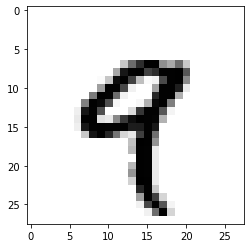

time: 118 ms (started: 2021-07-17 21:03:49 +08:00)


In [122]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

自然，对应的标签就是整数 9：

In [123]:
train_labels[4]

9

time: 1.16 ms (started: 2021-07-17 21:03:49 +08:00)


### 在 NumPy 中操作张量

在前面的示例中，我们使用语法 train_images[i] 选择了第一个轴旁边的特定数字。 选择张量中的特定元素称为张量切片。 让我们看看您可以在 NumPy 数组上执行的张量切片操作。

以下示例选择数字 #10 到 #100（不包括 #100）并将它们放入形状为 (90, 28, 28) 的数组中：

In [124]:
my_slice = train_images[10:100]

time: 755 ms (started: 2021-07-17 21:03:49 +08:00)


In [125]:
my_slice.shape

(90, 28, 28)

time: 928 ms (started: 2021-07-17 21:03:50 +08:00)


它相当于这个更详细的符号，它指定了沿着每个张量轴的切片的开始索引和停止索引。 请注意，这相当于选择整个轴：

In [126]:
my_slice = train_images[10:100, :, :]

time: 726 ms (started: 2021-07-17 21:03:51 +08:00)


In [127]:
my_slice.shape

(90, 28, 28)

time: 2.43 ms (started: 2021-07-17 21:03:51 +08:00)


In [128]:
my_slice = train_images[10:100, 0:28, 0:28]

time: 502 µs (started: 2021-07-17 21:03:51 +08:00)


In [129]:
my_slice.shape

(90, 28, 28)

time: 2.17 ms (started: 2021-07-17 21:03:51 +08:00)


通常，您可以选择沿每个张量轴的任意两个索引之间的切片。 例如，为了在所有图像的右下角选择 14 × 14 像素，您可以这样做：

In [130]:
my_slice = train_images[:, 14:, 14:]

time: 447 µs (started: 2021-07-17 21:03:51 +08:00)


也可以使用负索引。 就像 Python 列表中的负索引一样，它们表示相对于当前轴末端的位置。 为了将图像裁剪为以中间为中心的 14 × 14 像素块，您可以执行以下操作：

In [131]:
my_slice = train_images[:, 7:-7, 7:-7]

time: 721 µs (started: 2021-07-17 21:03:51 +08:00)


### 数据批次的概念

通常，您在深度学习中遇到的所有数据张量中的第一个轴（轴 0，因为索引从 0 开始）将是样本轴（有时称为样本维度）。 在 MNIST 示例中，“样本”是数字图像。

此外，深度学习模型不会一次处理整个数据集； 相反，他们将数据分成小批量。 具体来说，这是我们的一批 MNIST 数字，批大小为 128：

In [132]:
batch = train_images[:128]

time: 695 µs (started: 2021-07-17 21:03:51 +08:00)


这是下一批：

In [133]:
batch = train_images[128:256]

time: 1.31 ms (started: 2021-07-17 21:03:51 +08:00)


第n批:

In [134]:
n = 3
batch = train_images[128 * n:128 * (n + 1)]

time: 1.02 ms (started: 2021-07-17 21:03:51 +08:00)


在考虑这样的批次张量时，第一个轴（轴 0）称为批次轴批次维度。 这是您在使用 Keras 和其他深度学习库时会经常遇到的术语。

### 数据张量的真实例子

让我们通过一些类似于您稍后将遇到的示例来使数据张量更加具体。 您将操作的数据几乎总是属于以下类别之一：
* 矢量数据 - 2阶形状张量（样本、特征），其中每个样本是数值属性（“特征”）的向量。
* 时间序列数据或序列数据 — 3阶形状张量（样本、时间步长、特征），其中每个样本是一个（长度为 ）特征向量的序列。
* 图像 - 4阶级形状张量（样本、高度、宽度、通道），其中每个样本是一个 2D 像素网格，每个像素由值向量（“通道”）表示。
* 视频 - 5阶形状张量（样本、帧、高度、宽度、通道），其中每个样本是一个（长度帧）图像序列

### 矢量数据

这是最常见的情况之一。 在这样的数据集中，每个单个数据点都可以编码为一个向量，因此一批数据将被编码为一个秩为 2 的张量（即向量数组），其中第一个轴是样本轴， 第二个轴是特征轴。

我们来看两个例子：
* 一个人的精算数据集，我们在其中考虑每个人的年龄、性别和收入。 每个人都可以表征为一个包含 3 个值的向量，因此 100,000 人的整个数据集可以存储在形状为 (100000, 3) 的 2 级张量中。
* 文本文档的数据集，我们通过每个单词出现在其中的次数来表示每个文档（在 20,000 个常用单词的字典中）。 每个文档都可以编码为一个包含 20,000 个值的向量（字典中每个单词一个计数），因此可以将包含 500 个文档的整个数据集存储在形状为 (500, 20000) 的张量中。

### 时间序列数据或序列数据

每当您的数据（或序列顺序的概念）中的时间很重要时，将其存储在具有明确时间轴的 3 级张量中是有意义的。 每个样本都可以编码为一个向量序列（一个 rank-2 张量），因此一批数据将被编码为一个 rank-3 张量（见图 2.3）。

![](https://tva1.sinaimg.cn/large/008i3skNly1gsjxu1s347j31fy0lstaj.jpg)

按照惯例，时间轴始终是第二个轴（索引 1 的轴）。 让我们看几个例子：
* 股票价格数据集。 每分钟，我们存储股票的当前价格，过去一分钟的最高价格，以及过去一分钟的最低价格。 因此，每一分钟都被编码为一个 3D 向量，一整天的交易被编码为一个形状为 (390, 3) 的矩阵（一个交易日有 390 分钟），250 天的数据可以存储在一个 3 级形状张量 (250, 390, 3)。 在这里，每个样本都是一天的数据。
* 推文数据集，我们将每条推文编码为 128 个唯一字符字母表中的 280 个字符序列。 在此设置中，每个字符都可以编码为大小为 128 的二进制向量（除了与字符对应的索引处的 1 条目之外的全零向量）。 然后可以将每条推文编码为形状为 (280, 128) 的 2 级张量，并且可以将 100 万条推文的数据集存储在形状为 (1000000, 280, 128) 的张量中。

### 图像数据

图像通常具有三个维度：高度、宽度和颜色深度。 尽管灰度图像（如我们的 MNIST 数字）只有一个颜色通道，因此可以存储在 2 阶张量中，但按照惯例，图像张量始终是 3 阶，灰度图像具有一维颜色通道。 因此，一批 128 张大小为 256 × 256 的灰度图像可以存储在形状为 (128, 256, 256, 1) 的张量中，一批 128 张彩色图像可以存储在形状为 (128, 256, 256, 3)（见图 2.4）。

![](https://tva1.sinaimg.cn/large/008i3skNly1gsjy2mn11nj30p80iyab6.jpg)

图像张量的形状有两种约定：通道最后约定（TensorFlow 中的标准）和通道优先约定（越来越不受欢迎）。

通道最后约定将颜色深度轴放在末尾：（样本、高度、宽度、颜色深度）。 同时，通道优先约定将颜色深度轴放在批处理轴之后：（样本，颜色深度，高度，宽度）。 使用通道优先约定，前面的示例将变为 (128, 1, 256, 256) (128, 3, 256, and 256)。 Keras API 提供对这两种格式的支持。

### 视频数据

视频数据是少数需要 5 级张量的真实世界数据类型之一。 视频可以理解为一系列帧，每一帧都是一张彩色图像。 因为每一帧都可以存储在一个rank-3张量（height, width, color_depth）中，一个帧序列可以存储在一个rank-4张量（frames, height, width, color_depth）中，从而得到一批不同的视频 可以存储在 5 级形状张量中（样本、帧、高度、宽度、颜色深度）。

例如，以每秒 4 帧采样的 60 秒、144 × 256 YouTube 视频剪辑将有 240 帧。 一批四个这样的视频剪辑将存储在一个形状为 (4, 240, 144, 256, 3) 的张量中。 总共有 106,168,320 个值！ 如果张量的 , dtype float32 那么每个值将以 32 位存储，因此张量将表示 405 MB。 重的！ 您在现实生活中遇到的视频要轻得多，因为它们没有存储在 .float32 和 float32 中，它们通常被大量压缩（例如以 MPEG 格式）。

## 神经网络的齿轮：张量运算 

就像任何计算机程序最终都可以简化为对二进制输入（AND、OR、NOR 等）进行的一小组二进制运算一样，深度神经网络学习的所有变换都可以简化为少量张量运算（ 或 )张量函数应用于数值数据的张量。 例如，可以添加张量、乘张量等。

在我们最初的示例中，我们通过在每个 Dense 彼此之上堆叠层来构建我们的模型。 Keras 层实例如下所示：

In [135]:
keras.layers.Dense(512, activation="relu")

time: 3.47 ms (started: 2021-07-17 21:03:51 +08:00)


这一层可以被解释为一个函数，它将一个矩阵作为输入并返回另一个矩阵——输入张量的新表示。 具体来说，函数如下（其中W是矩阵，b是向量，都是层的属性）：
```python
output = relu(dot(input, W) + b)
```

让我们解开这个。 我们这里有三个张量操作：
* 输入张量和名为点 W 的张量之间的点积 ( )
* 结果矩阵和向量 b + 之间的加法 ( )
* Relu 操作：是max(x,0). “relu”代表“整流线性单元”。

> 尽管本节完全涉及线性代数表达式，但您不会在这里找到任何数学符号。 我发现没有数学背景的程序员可以更容易地掌握数学概念，如果将它们表示为简短的 Python 片段而不是数学方程。 所以我们将在整个过程中使用 NumPy 和 TensorFlow 代码。

### 元素操作

操作和加法是逐元素操作：将 relu 独立应用于所考虑的张量中的每个条目的操作。 这意味着这些操作非常适合大规模并行实现（实现，向量化的术语来自 1970-1990 时期的向量处理器超级计算机架构）。 如果你想编写一个简单的元素操作的 Python 实现，你可以使用一个循环，因为在这个元素操作的简单实现中：relu
```python
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
 return x
```

你可以做同样的add函数：
```python
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
 return x
```

根据相同的原理，您可以进行逐元素乘法、减法等。

在实践中，在处理 NumPy 数组时，这些操作可以作为优化良好的内置 NumPy 函数使用，它们本身将繁重的工作委托给基本线性代数
子程序 (BLAS) 实施。 BLAS 是低级、高度并行、高效的张量操作例程，通常在 Fortran 或 C 中实现。

因此，在 NumPy 中，您可以执行以下逐元素操作，而且速度会非常快：
```python
import numpy as np
z = x + y
z = np.maximum(z, 0.)
```

让我们实际计算一下差异：

In [136]:
import time
x = np.random.random((20, 100))
y = np.random.random((20, 100))
t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
    
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.01 s
time: 6.57 ms (started: 2021-07-17 21:03:51 +08:00)


这需要 0.02 秒。 同时，天真的版本需要惊人的 2.45 秒：

In [137]:
%timeit naive_relu(x)

1.03 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time: 8.58 s (started: 2021-07-17 21:03:51 +08:00)


同样，当在 GPU 上运行 TensorFlow 代码时，元素操作是通过完全矢量化的 CUDA 实现来执行的，可以最好地利用高度并行的 GPU 芯片架构。

### 广播

我们早期的 naive 实现仅支持添加具有 naive_add 相同形状的 rank-2 张量。 但是在前面介绍的层中，我们添加了一个带有 Dense 向量的 rank-2 张量。 当相加的两个张量的形状不同时，加法会发生什么？

在可能的情况下，如果没有歧义，将广播较小的张量以匹配较大张量的形状。 广播包括两个步骤：
* 轴（称为广播轴）被添加到较小的张量以匹配 ndim 较大的张量。
* 较小的张量与这些新轴一起重复，以匹配较大张量的完整形状。

我们来看一个具体的例子。 考虑形状和形状：X (32, 10) y (10,)

In [138]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))

time: 517 µs (started: 2021-07-17 21:04:00 +08:00)


首先，我们向 中添加一个空的第一个轴，其形状变为：y (1, 10)

In [139]:
y = np.expand_dims(y, axis=0)
y.shape

(1, 10)

time: 5.66 ms (started: 2021-07-17 21:04:00 +08:00)


In [140]:
#或者采用这种形式，利用了python set的特性：
y.reshape((1,)+y.shape).shape

(1, 1, 10)

time: 2.35 ms (started: 2021-07-17 21:04:00 +08:00)


然后，我们沿着这个新轴重复 32 次，这样我们最终会得到一个形状为 y Y (32, 10) Y[i, :] == y i range(0, 32) 的张量，其中 in ：

In [141]:
Y = np.concatenate([y] * 32, axis=0)

time: 795 µs (started: 2021-07-17 21:05:43 +08:00)


此时，我们可以继续添加X和Y，因为它们具有相同的形状

在实现方面，没有创建新的2阶张量，因为那会非常低效。 重复操作完全是虚拟的：它发生在算法级别而不是内存级别。 但是，将向量与新轴一起重复 10 次的想法是一种有用的心理模型。 下面是一个简单的实现：

In [143]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

time: 598 µs (started: 2021-07-17 21:31:38 +08:00)


对于广播，如果一个张量具有形状 (a, b, … n, n + 1, … m) 而另一个具有形状 (n, n + 1, … m)，则通常可以应用双张量元素操作。 然后广播将自动发生在轴 a 到 n - 1

以下示例通过广播将逐元素操作应用于两个不同最大形状的张量：

In [144]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)

time: 1.32 ms (started: 2021-07-17 21:33:28 +08:00)


### 张量积

张量积点积或（不要与元素乘积混淆， * 运算符）是最常见、最有用的张量运算之一。

在 NumPy 中，张量积是使用该函数完成的（因为张量积的数学 np.dot 表示法通常是一个点）。

In [146]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)
z

9.37882579185326

time: 2.2 ms (started: 2021-07-17 21:35:43 +08:00)


In [148]:
x@y

9.37882579185326

time: 1.97 ms (started: 2021-07-17 21:35:59 +08:00)


在数学符号中，您会用一个点 (•) 来表示操作：

In [ ]:
z = x • y

在数学上，点操作有什么作用？ 让我们从两个向量 x 和 y的点积开始。 计算如下：

In [149]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

time: 674 µs (started: 2021-07-17 21:37:28 +08:00)


您会注意到两个向量之间的点积是一个标量，并且只有具有相同元素数量的向量才与点积兼容。

您还可以采用矩阵X和向量y之间的点积，它返回向量 ，其中系数是 和 的行之间的点积。 其实现为
如下：

In [150]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

time: 529 µs (started: 2021-07-17 21:41:22 +08:00)


您还可以重用我们之前编写的代码，其中突出显示了矩阵向量乘积和向量乘积之间的关系：

In [152]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

time: 693 µs (started: 2021-07-17 21:42:41 +08:00)


请注意，只要两个张量之一大于 1，就不再是 ndim 点对称，也就是说，与 不同。

当然，点积可以推广到具有任意数量轴的张量。 最常见的应用可能是两个矩阵之间的点积。 您可以取两个矩阵的点积和 ( ) 当且仅当 x y dot(x, y) x.shape[1] == y.shape[0]。 结果是一个形状为 (x.shape[0], y.shape[1]) 的矩阵，其中系数是 的行和列之间的向量积。 这是简单的实现：

In [155]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1])) 
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

time: 858 µs (started: 2021-07-17 21:44:56 +08:00)


为了理解点积形状的兼容性，它有助于通过对齐它们来可视化输入和输出张量，如图 2.5 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gska6m4bphj30s00meab4.jpg)

x、 和 被描绘为矩形（系数的文字框）。 由于x 的行和 的 y列必须具有相同的大小，因此 的宽度必须与 的高度匹配。 y x y 如果您继续开发新的机器学习算法，您可能会经常绘制此类图表。

更一般地，您可以在高维张量之间取点积，如下 与前面为 2D 情况概述的形状兼容性相同的规则：

In [ ]:
(a, b, c, d) • (d,) -> (a, b, c)
(a, b, c, d) • (d, e) -> (a, b, c, e)

### 张量整形

需要理解的第三种张量运算是张量整形。 尽管在我们的第一个神经网络示例中的层中没有使用它，但我们在将数字数据输入模型之前对数字数据进行 Dense 预处理时使用了它：

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))

重塑张量意味着重新排列其行和列以匹配目标形状。 自然地，重新整形的张量与初始张量具有相同的系数总数。 通过简单的例子可以最好地理解重塑：

In [158]:
x = np.array([[0., 1.],
               [2., 3.],
               [4., 5.]])

time: 365 µs (started: 2021-07-17 21:49:24 +08:00)


In [159]:
x.shape

(3, 2)

time: 1.39 ms (started: 2021-07-17 21:49:28 +08:00)


In [160]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

time: 2.04 ms (started: 2021-07-17 21:49:38 +08:00)


In [161]:
x = x.reshape((2, 3))
x

array([[0., 1., 2.],
       [3., 4., 5.]])

time: 2.69 ms (started: 2021-07-17 21:49:55 +08:00)


经常遇到的一种特殊的重塑情况是转置，转置矩阵意味着交换它的行和列，这样就变成了：

In [164]:
x = np.zeros((300, 20))
x.shape

(300, 20)

time: 1.41 ms (started: 2021-07-17 21:51:22 +08:00)


In [165]:
x = np.transpose(x)
x.shape

(20, 300)

time: 2.11 ms (started: 2021-07-17 21:51:38 +08:00)


### 张量运算的几何解释

因为张量运算所操纵的张量的内容可以解释为一些几何空间中点的坐标，所以所有的张量运算都有几何解释。 例如，让我们考虑加法。 我们将从以下向量开始：

In [166]:
A = [0.5, 1]

time: 306 µs (started: 2021-07-17 21:52:47 +08:00)


它是二维空间中的一个点（见图 2.6）。 通常将向量描绘为连接原点和点的箭头，如图 2.7 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskaewzyusj30h80m4mxl.jpg)

让我们考虑一个新点，B = [1, 0.25]，我们将把它添加到前一个点上。 这是通过将矢量箭头链接在一起以几何方式完成的，结果位置是表示前两个矢量之和的矢量（见图 2.8）。 可以看到，在向量A上加上向量B代表了在新位置复制点A的动作，它到原点A的距离和方向由向量B决定。如果你将相同的向量加到一个组 平面中的点（一个“对象”），您将在新位置创建整个对象的副本（见图 2.9）。 因此，张量加法表示将对象（移动对象而不使其变形）在某个方向上平移一定量的动作。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskahbh25zj30ws0u0gmz.jpg)

一般而言，平移、旋转、缩放、倾斜等基本几何运算都可以表示为张量运算。 这里有一些例子。

* 平移：正如你刚刚看到的，向一个点添加一个向量会在一个固定的方向上移动这个点一个固定的量。 应用于一组点（例如 2D 对象），这称为“平移”（见图 2.9）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskaj7k4foj31560mgmyn.jpg)

* 旋转：可以通过一个 2 × 2 矩阵 R = [[cos(theta), sin(theta)], [-sin(theta) 的点积来实现 2D 向量旋转角度 theta（见图 2.10） ), cos(theta)]]。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskakniqqlj314c0l0jsy.jpg)

* 缩放：图像的垂直和水平缩放（见图 2.11）可以通过具有 2 x 2 矩阵的点积来实现（请注意，这种矩阵称为“对角 S = 矩阵”，因为它只有非 其“对角线”中的系数为零，从左上角到右下角）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskalhqmg6j314q0kujsl.jpg)

* 线性变换：具有任意矩阵的点积实现了线性变换。请注意，上面看到的 和 是定义线性变换。 缩放旋转
* 仿射变换：仿射变换（见图 2.12）是线性变换（通过一些矩阵的点积实现）和平移（通过向量加法实现）的组合。 您可能已经认识到，这正是该层实现的 y = W • x + b 计算！ 没有激活的层 Dense Dense
函数是一个仿射层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskaml9oqij313w0i40ty.jpg)

如果你重复应用它们中的许多，你仍然会得到一个仿射变换（所以你可以首先应用那个仿射变换）。 让我们用两个来试试：affine2(affine1(x)) = W2 • (W1 • x + b1) + b2 = (W2 • Wa) • x + (W2 • b1 + b2)。 这是一个仿射变换，其中线性部分是矩阵 W2 • W1，平移部分是向量 W2 • b1 + b2。 因此，完全由没有激活的层组成的多层神经网络将等效于密集单层。 这个“深度”神经网络只是一个变相的线性模型！ 这就是我们需要激活函数的原因，例如（参见图 relu 2.13 中的操作）。 多亏了激活函数，可以制作一个层链来实现密集的非常复杂的非线性几何变换，从而为您的深度神经网络提供非常丰富的假设空间。 我们将在下一章更详细地介绍这个想法。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskaook914j31580jadh7.jpg)

### 深度学习的几何解释

您刚刚了解到神经网络完全由张量运算链组成，所有这些张量运算只是输入数据的简单几何变换。因此，您可以将神经网络解释为高维空间中非常复杂的几何变换，通过一系列简单的步骤实现。

在 3D 中，以下心理图像可能很有用。想象两张彩色纸：一张红色一张蓝色。把一个放在另一个上面。现在把它们揉成一个小球。那个皱巴巴的纸球是你的输入数据，每张纸都是分类问题中的一类数据。神经网络的目的是找出纸球的变形，将它弄皱，从而使这两个类再次完全分离。通过深度学习，这将作为 3D 空间的一系列简单变换来实现，例如您可以用手指在纸球上应用的变换，一次一个动作。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gskarwqwnhj31500imtaf.jpg)

解开纸球是机器学习的意义所在：在高维空间（流形是一个连续的流形表面，就像我们皱巴巴的纸一样）为复杂的、高度折叠的数据找到整洁的表示。 在这一点上，您应该对深度学习为何擅长于此有一个很好的直觉：它采用的方法是将复杂的几何变换逐步分解为一长串基本变换，这几乎是人类遵循的策略 解开一个纸球。 深层网络中的每一层都应用了一种转换来稍微解开数据——而深层次的堆栈使一个极其复杂的解开过程变得容易处理。

## 神经网络引擎：基于梯度的优化

正如您在上一节中看到的，我们第一个模型示例中的每个神经层都按如下方式转换其输入数据：

In [ ]:
output = relu(dot(input, W) + b)

在这个表达式中，W和b是作为层属性的张量。 它们被称为层的权重或可训练参数（分别为 和 属性）。 这些内核偏置权重包含模型从暴露于训练数据中学到的信息。

最初，这些权重矩阵填充有小的随机值（称为随机初始化的步骤）。 当然，没有理由期望 relu(dot(input, W) + b) W ，当 和 是随机的，会产生任何有用的表示。 由此产生的表示是无意义的——但它们是一个起点。 接下来是根据反馈信号逐渐调整这些权重。 这种渐进式调整，也称为 ，基本上是机器学习的全部内容的训练学习。

这发生在所谓的训练循环中，其工作原理如下。 循环重复这些步骤，直到损失看起来足够低：
1. 绘制一批训练样本x和对应的目标y_true。
2. 运行模型（称为 x 前向传递的步骤）以获得预测 y_pred。
3. 计算批次上模型的损失，这是 y_pred 和 y_true 之间不匹配的度量。
4. 以稍微减少该批次损失的方式更新模型的所有权重。

你最终会得到一个训练数据损失非常低的模型：预测 y_pred 和预期目标 y_true 之间的低不匹配。 该模型已经“学会”将其输入映射到正确的目标。 从远处看，它可能看起来像魔术，但是当您将其简化为基本步骤时，它就会变得很简单。

第 1 步听起来很简单——只是 I/O 代码。 第 2 步和第 3 步只是少数张量运算的应用，因此您可以完全根据您在上一节中学到的知识来实现这些步骤。 困难的部分是第 4 步：更新模型的权重。 给定模型中的单个权重系数，您如何计算该系数是否应该增加或减少，以及增加多少？

一种简单的解决方案是冻结模型中除考虑的一个标量系数之外的所有权重，并为该系数尝试不同的值。 假设系数的初始值为 0.3。 前向传递一批数据后，该批上的模型损失为0.5。 如果您将系数的值更改为 0.35 并重新运行前向传递，损失将增加到 0.6。 但是如果你将系数降低到 0.25，损失就会下降到 0.4。 在这种情况下，似乎将系数更新 -0.05 将有助于最小化损失。 这必须对模型中的所有系数重复。

但是这样的方法效率极低，因为您需要为每个单独的系数（其中有很多，通常是数千个，有时高达数百万个）计算两次前向传递（这是昂贵的）。 值得庆幸的是，有一个更好的方法：梯度
下降。

梯度下降是为现代神经网络提供动力的优化技术。这是它的要点。我们模型中使用的所有函数（例如 或 ）都以点 + 平滑和连续的方式转换其输入：例如，如果您查看 ，仅 z = x + y 的微小变化会导致z 的微小变化，如果你知道y中变化的方向，你就可以推断出z中变化的方向。在数学上，你会说这些函数是 z 可微的。如果将这些函数链接在一起，您获得的更大的函数仍然是可微的。特别是，这适用于将模型系数映射到模型在一批数据上的损失的函数：模型系数的微小变化会导致损失值发生微小的、可预测的变化。这使您能够使用称为 的数学运算符来描述当您在不同方向上移动模型系数时损失的梯度如何变化。如果您计算此梯度，您可以使用它在减少损失的方向上移动系数（在一次更新中一次全部完成，而不是一次一个）。

如果您已经知道可微分的含义和 a 是什么，您可以跳到第 2.4 节梯度。 否则，以下两节将帮助您理解这些概念。

### 什么是导数？

考虑一个连续、平滑的函数，将一个数字x映射到一个新数字y。 我们 f(x) = y 可以使用下面的函数作为例子：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm5zeuenoj310w0mmmxt.jpg)

因为函数是连续的，x 的微小变化只能导致 y 连续的微小变化——这就是连续性背后的直觉。 假设您对x增加了一个很小的epsilon_x ，这导致y有一个小的epsilon_y变化：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm622j9x3j310y0lwgmn.jpg)

另外，因为函数是光滑的（它的曲线没有任何陡峭的角度），当epsilon_x足够小时，在某个点附近，f可以近似为斜率的线性p函数，这样epsilon_y 就变成了一个a * epsilon_x:

In [ ]:
f(x + epsilon_x) = y + a * epsilon_x

显然，这种线性近似只有x在足够接近p时才有效。

斜率 a 称为 p 中 f 的斜率。 如果为负，则表示导数 f p a x p 附近的微小变化将导致减少（如图 2.17 所示）； 如果为正，则 f(x) a in 的微小变化将导致 的增加。 此外，（x f(x) 的幅度导数）的绝对值告诉您这种增加或减少发生的速度。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm69buf6jj311e0o0wff.jpg)

> 省略部分关于微分的内容，因为大学都学过

### 张量运算的导数：梯度

> 省略

### 随机梯度下降

给定一个可微函数，理论上可以通过解析找到它的最小值：众所周知，函数的最小值是导数为 0 的点，因此您要做的就是找到导数为 0 的所有点并检查哪个点 在这些点中，该函数的值最低。

应用于神经网络，这意味着通过分析找到产生最小可能损失函数的权重值组合。 这可以通过求解方程 grad(f(W), W) = 0 来完成。 这是变量N的多项式方程，其中N是模型中系数的数量 。 尽管可以解出 N = 2 或 的这样的方程，但对于真实的神经网络来说，这样做是棘手的，其中参数的数量是 N = 3，从不低于几千个，通常可以达到几千万。

相反，您可以使用本节开头概述的四步算法：根据随机批次数据的当前损失值一点一点地修改参数。 因为你正在处理一个可微函数，你可以计算它的梯度，这为你提供了一种实现步骤 4 的有效方法。 如果你在梯度的相反方向更新权重，每次损失都会少一点：
1. 绘制一批训练样本x和对应的目标y_true。
2. 在 x 上运行模型以获得预测（这称为 y_pred 前向传递）。
3. 计算批次上模型的损失，这是 y_pred 和 y_true 之间不匹配的度量。
4. 计算关于模型参数的损失梯度（这称为反向传播）。
5. 在与梯度相反的方向稍微移动参数，例如 W -= learning_rate * gradient - 从而稍微减少批次的损失。 学习率（这里是learning_rate）将是一个调节“速度”的标量因子梯度下降过程。

够简单！ 我们刚刚描述的称为小批量随机梯度下降（小批量 SGD）。 该术语指的是每批数据都是随机抽取的（是 的科学同义词）。 图 2.18 说明了在随机随机一维中会发生什么，当模型只有一个参数而您只有一个训练样本时。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm6j1y25zj30y30u0ta7.jpg)

如您所见，直观地为 learning_rate 因子选择一个合理的值很重要。 如果它太小，沿着曲线下降将需要多次迭代，并且可能会陷入局部最小值。 如果 learning_rate 太大，您的更新最终可能会将您带到曲线上完全随机的位置。

请注意，小批量 SGD 算法的一个变体是在每次迭代时绘制单个样本和目标，而不是绘制一批数据。 这将是 SGD（与真正的小批量 SGD 相反）。 或者，走向相反的极端，您可以对所有可用数据运行每一步，这称为批量梯度下降。 每次更新都会更准确，但要贵得多。 这两个极端之间的有效折衷是使用合理大小的小批量。

虽然图 2.18 展示了在一维参数空间中的梯度下降，但实际上你将在高维空间中使用梯度下降：神经网络中的每个权重系数都是空间中的一个自由维度，可能有数万甚至数百万 其中。 为了帮助您建立对损失表面的直觉，您还可以可视化沿 2D 损失表面的梯度下降，如图 2.19 所示。 但是你不可能想象出训练神经网络的实际过程是什么样的——你不能以一种对人类有意义的方式来表示一个 1,000,000 维的空间。 因此，请记住，您通过这些低维表示形成的直觉在实践中可能并不总是准确的。 从历史上看，这一直是深度学习研究领域问题的根源。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm6qkwr29j313s0rwwgl.jpg)

此外，存在多种 SGD 变体，它们在计算下一次权重更新时会考虑先前的权重更新，而不仅仅是查看梯度的当前值。 例如，有动量的 SGD，以及 Adagrad、RMSprop 和其他几个。 这种变体被称为优化方法优化器或。 特别是，在许多这些变体中使用的 的概念值得您注意。 Momentum 解决了 SGD 的两个问题：收敛速度和局部最小值。 考虑图 2.20，它显示了作为模型参数函数的损失曲线。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm6rqfeofj31480osgmx.jpg)

如您所见，在某个参数值附近，有一个局部最小值：在该点附近，向左移动会导致损失增加，但向右移动也会导致损失增加。 如果正在考虑的参数通过 SGD 以较小的学习率进行优化，那么优化过程将卡在局部最小值而不是达到全局最小值。

您可以通过使用从物理学中汲取灵感的动量来避免此类问题。 这里一个有用的心理形象是将优化过程视为一个沿着损失曲线滚动的小球。 如果它有足够的动量，球就不会卡在峡谷中，最终会达到全局最小值。 动量是通过在每一步移动球来实现的，不仅基于当前的斜率值（当前加速度），还基于当前速度（由过去的加速度产生）。 实际上，这意味着不仅要根据当前的 w 梯度值更新参数，还要根据先前的参数更新来更新参数，例如在这个简单的实现中：

In [ ]:
past_velocity = 0.
momentum = 0.1
while loss > 0.01:
    w, loss, gradient = get_current_parameters()
    velocity = past_velocity * momentum - learning_rate * gradient
    w = w + momentum * velocity - learning_rate * gradient
    past_velocity = velocity
    update_parameter(w)

### 链式导数：反向传播算法

在上面的算法中，我们随便假设，因为一个函数是可微的，我们可以很容易地计算它的梯度。 但这是真的吗？ 在实践中我们如何计算复杂表达式的梯度？ 在我们的两层网络示例中，我们如何获得与权重有关的损失梯度？ 这就是反向传播算法的用武之地。

**链式法则**

反向传播是一种使用简单操作（例如加法、relu 或张量积）的导数来轻松计算这些原子操作的任意复杂组合的梯度的方法。 至关重要的是，神经网络由许多链接在一起的张量运算组成，每个张量运算都有一个简单的、已知的导数。 例如，我们第一个示例中的模型可以表示为由变量W1 b1 W2和b2（分别属于第一层和第二层Dense顶部）参数化的函数，涉及原子操作dot，relu，softmax和+，以及我们的损失函数loss，它们都很容易区分：

In [ ]:
loss_value = loss(y_true, softmax(dot(relu(dot(inputs, W1) + b1), W2) + b2))

微积分告诉我们，可以使用以下恒等式推导出这样的函数链，称为 ：

考虑两个函数f和g，以及组合函数fg，使得 y = fg(x) == f(g(x))：

In [1]:
def fg(x):
    x1 = g(x)
    y = f(x1)
    return y

然后链式法则指出 grad(y, x) == grad(y, x1) * grad(x1, x)。 只要您知道 f 和 g 的导数，就可以计算出 fg 的导数。 链式规则的命名是这样的，因为当你添加更多的中间函数时，它开始看起来像一个链：

In [ ]:
def fghj(x):
    x1 = j(x)
    x2 = h(x1)
    x3 = g(x2)
    y = f(x3)
    return y
grad(y, x) == grad(y, x3) * grad(x3, x2) * grad(x2, x1) * grad(x1, x)

将链式法则应用于神经网络梯度值的计算，产生了一种称为反向传播的算法。 让我们具体看看它是如何工作的。

**使用计算图进行自动微分**

考虑反向传播的一种有用方法是计算图。 计算图是 TensorFlow 和深度学习革命的核心数据结构。 它是一个有向无环运算图——在我们的例子中是张量运算。 例如，这是我们第一个模型的图形表示：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm7d5g6hyj30iu0m23z7.jpg)

计算图在计算机科学中是一个非常成功的抽象，因为它们使我们能够将计算视为数据：可计算表达式被编码为机器可读的数据结构，可以用作另一个程序的输入或输出。 例如，您可以想象一个程序接收一个计算图并返回一个新的计算图，该计算图实现了相同计算的大规模分布式版本——这意味着您可以分发任何计算而无需自己编写分发逻辑。 或者想象一下……一个接收计算图并可以自动生成它所代表的表达式的导数的程序。 如果您的计算表示为显式图形数据结构，而不是 .py 文件中的 ASCII 字符行，那么做这些事情会容易得多。

为了清楚地解释反向传播，让我们看一个计算图的非常基本的例子。 我们将考虑上图的简化版本，其中我们只有一个线性层并且所有变量都是标量。 我们将采用两个标量变量 w、b，一个标量输入 x，并对它们应用一些操作以组合成输出 y。 最后，我们将应用绝对值误差损失函数：loss_val = abs(y_true - y)。 由于我们希望以最小化 loss_val 的方式更新 w 和 b，因此我们对计算 grad(loss_val, b) 和 grad(loss_val, w) 感兴趣。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm7f17o5jj30oe0qmdgm.jpg)

让我们为图 x 中的“输入节点”设置具体值，即输入 x、目标 y_true、w 和 b。 我们将这些值从上到下传播到图中的所有节点，直到达到 。 这是 loss_val 前向传递。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm7h150ehj30ks0oymxx.jpg)

现在让我们“反转”图：对于图中从 a 到 b 的每条边，我们将创建一条从 b 到 a 的相反边，并询问“当 a 变化时 b 变化多少？” 也就是说，什么是 grad(b, a)？ 我们将用这个值注释每条倒边。 这个反向图代表反向传播。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm7ipqernj30z80p4q4a.jpg)

我们有：
* grad(loss_val, x2) = 1，因为x2 随着 epsilon 的变化，loss_val = abs(4 - x2) 也有相同的变化。
* grad(x2, x1) = 1，因为x1随着 epsilon 量的变化，x2 = x1 + b = x1 +1 变化量相同。
* grad(x2, b) = 1，因为b随着 epsilon 量的变化，x2 = x1 + b = 6 + b 变化量相同。
* grad(x1, w) = 2，因为w随着数量 epsilon 的变化，x1 = x * w = 2 * w 变化了 2 * epsilon。

链式法则对这个反向图说的是，您可以通过将连接两个节点的路径上的每条边的导数相乘来获得一个节点相对于另一个节点的导数。 例如，grad(loss_val, w) = grad(loss_val, x2) * grad(x2, x1) * grad(x1, w)。 （见图 2.25）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm7l9s9t0j311q0ni75k.jpg)

通过将链式法则应用到我们的图中，我们得到了我们想要的东西：
* grad(loss_val, w) = 1 * 1 * 2 = 2
* grad(loss_val, b) = 1 * 1 = 1

> 如果在反向图中有多个路径连接两个感兴趣的节点 a, b，我们将通过对所有路径的贡献求和来获得 grad(b, a)。

有了这个，你就看到了反向传播的作用！ 反向传播只是将链式法则应用于计算图。 仅此而已。 反向传播从最终的损失值开始，从顶层到底层反向传播，计算每个参数对损失值的贡献。 这就是“反向传播”名称的由来：我们“反向传播”计算图中不同节点的损失贡献。

现在和未来几年，人们在能够自动微分的现代框架中实现神经网络，例如 TensorFlow。 自动微分是通过上面介绍的那种计算图来实现的。 自动微分使得检索可微张量操作的任意组合的梯度成为可能，除了写下前向传递外，无需做任何额外的工作。 当我在 2000 年代用 C 编写我的第一个神经网络时，我不得不手动编写我的梯度。 现在，多亏了现代自动微分工具，您将永远不必自己实现反向传播。 认为自己很幸运！

**Tensorflow中的梯度tape**

您可以利用 TensorFlow 强大的自动微分功能的 API 是 GradientTape。 它是一个 Python 作用域，它将以计算图（有时称为“磁带”）的形式“记录”在其中运行的张量操作。 然后，该图可用于检索任何输出相对于任何变量或变量集(tf.Variable 类的实例）的梯度。 tf.Variable是一种特定类型的张量，用于保持可变状态——例如，神经网络的权重总是 tf.Variable 实例。

In [4]:
import tensorflow as tf
x = tf.Variable(0.) 
with tf.GradientTape() as tape: 
    y = 2 * x + 3 
grad_of_y_wrt_x = tape.gradient(y, x)

1. 实例化一个标量，初始值为 0 变量
2. 打开 GradientTape 范围
3. 在作用域内，对我们的变量应用一些张量操作
4. 使用磁带检索输出相对于我们的变量 y x 的梯度

GradientTape 使用张量操作：

In [13]:
x = tf.Variable(tf.random.uniform((2, 2))) 
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

1. 实例化一个具有形状和初始值全零的变量 (2, 2)
2. grad_of_y_wrt_x 是一个形状 (2, 2)（如 x）的张量，描述了 y = 2 * a + 3 x = [[0, 0], [0, 0]] 周围的曲率

它还适用于变量列表：

In [14]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

* grad_of_y_wrt_W_and_b 是两个张量的列表，分别与 W和b 具有相同的形状

您将在下一章中了解梯度胶带。

## 回顾我们的第一个例子

您已接近本章的结尾，现在您应该对神经网络的幕后发生的事情有一个大致的了解。 本章开头的神奇黑匣子已经变成了更清晰的图景，如图 2.26 所示：模型由链接在一起的层组成，将输入数据映射到预测。 然后，损失函数将这些预测与目标进行比较，产生一个损失值：衡量模型预测与预期匹配程度的度量。 优化器使用这个损失值来更新模型的权重。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsm82d0rchj30ss0m40u9.jpg)

让我们回到第一个示例并根据您在前几节中学到的内容来回顾它的每一部分。
这是输入数据：

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

time: 380 ms (started: 2021-07-19 14:12:06 +08:00)


现在您了解输入图像存储在 NumPy 张量中，这里的张量格式分别为 float32 (60000, 784)（训练数据）和（10000, 784）（测试数据）形状的张量。

这是我们的模型：

In [4]:
from tensorflow.keras import models, layers

time: 251 µs (started: 2021-07-19 14:12:08 +08:00)


In [19]:
model = models.Sequential([
    layers.Dense(512, activation="relu", input_shape=(784,)),
    layers.Dense(10, activation="softmax")
])

time: 16.2 ms (started: 2021-07-19 14:13:59 +08:00)


In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
time: 2.46 ms (started: 2021-07-19 14:14:01 +08:00)


现在你明白这个模型由两层链组成，每一层 Dense 对输入数据应用一些简单的张量操作，这些操作涉及权重张量。 作为层的属性的权重张量是模型知识持续存在的地方。

这是模型编译步骤：

In [21]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

time: 5.64 ms (started: 2021-07-19 14:14:04 +08:00)


现在您了解 sparse_categorical_crossentropy 是用作学习权重张量的反馈信号的损失函数，训练阶段将尝试将其最小化。 您还知道，这种损失的减少是通过小批量随机梯度下降实现的。 控制梯度下降的特定使用的确切规则由作为第一个参数传递的 rmsprop 优化器定义。 

最后，这是训练循环：

In [22]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 4s 7ms/step - loss: 0.2579 - accuracy: 0.9248
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1046 - accuracy: 0.9690
Epoch 3/5
469/469 [==============================] - 4s 7ms/step - loss: 0.0682 - accuracy: 0.9793
Epoch 4/5
469/469 [==============================] - 4s 7ms/step - loss: 0.0494 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 4s 7ms/step - loss: 0.0371 - accuracy: 0.9888


time: 18.1 s (started: 2021-07-19 14:14:06 +08:00)


现在您了解调用 时会发生什么：模型将开始以 128 个样本的小批量对拟合训练数据进行迭代，重复 5 次（对所有训练数据的每次迭代称为 ）。 对于每个批次，该模型将计算与权重有关的历元的损失梯度（使用反向传播算法，该算法源自微积分中的链式法则），并在将减少损失值的方向上移动权重 对于这批。

在这 5 个 epoch 之后，该模型将执行 2,345 次梯度更新（每个 epoch 469 次），并且模型的损失将足够低，该模型将能够以高精度对手写数字进行分类。

在这一点上，您已经了解了有关神经网络的大部分知识。 让我们通过在 TensorFlow 中“从头开始”逐步重新实现第一个示例的简化版本来证明这一点。

### 在 TensorFlow 中从头开始重新实现我们的第一个示例

有什么比从头开始实施所有内容更好地展示完整、明确的理解？ 当然，这里的“从头开始”是相对的：我们不会重新实现基本的张量操作，也不会实现反向传播。 但是我们将进入如此低的级别，以至于我们几乎不会使用任何 Keras 功能。

如果您还不了解此示例中的每个小细节，请不要担心。 下一章将更详细地介绍 TensorFlow API。 现在，请尝试遵循正在发生的事情的要点——这个例子的目的是帮助你使用具体的实现来明确你对深度学习数学的理解。 我们走吧！

**一个简单的全连接类**

您之前已经了解到，该层实现了以下输入转换，Dense，其中W和b是模型参数，并且激活是一个元素函数（通常是
relu，但它会用于最后一层）：

In [ ]:
output = activation(dot(W, input) + b)

让我们实现一个简单的 Python 类 NaiveDense，它创建两个 TensorFlow 变量和 W b，并公开一个应用上述转换的方法call。

In [30]:
import tensorflow as tf
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)
        
    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]

time: 735 µs (started: 2021-07-19 17:31:05 +08:00)


1. 创建一个形状为“(input_size, output_size)”的矩阵，用随机 W 值初始化。
2. 创建一个形状为 b (output_size,) 的向量，初始化为零。
3. 应用前向传播。
4. 检索图层权重的便捷方法。

**一个简单的序列类**

现在，让我们创建一个 NaiveSequential 类来链接这些层。 它包装了一个层列表，并公开了一个方法，这些方法只是按顺序调用输入上的底层层。 它还调用 features 一个属性来轻松跟踪图层的参数。

In [31]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
            return weights

time: 635 µs (started: 2021-07-19 17:31:38 +08:00)


使用这个 NaiveDense 类和这个 NaiveSequential 类，我们可以创建一个模拟 Keras 模型：

In [44]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 2

time: 3.62 ms (started: 2021-07-19 17:38:14 +08:00)


In [42]:
model.weights

[<tf.Variable 'Variable:0' shape=(784, 512) dtype=float32, numpy=
 array([[0.05474288, 0.03334844, 0.05399695, ..., 0.02889257, 0.09583582,
         0.00209544],
        [0.00046968, 0.04355458, 0.07128068, ..., 0.04350798, 0.00625761,
         0.02799137],
        [0.06705492, 0.09827209, 0.04390842, ..., 0.05562458, 0.08269938,
         0.04494333],
        ...,
        [0.01507559, 0.06134799, 0.05574847, ..., 0.09836749, 0.04171026,
         0.09820703],
        [0.09151063, 0.02694974, 0.04601102, ..., 0.02695199, 0.04244385,
         0.00907236],
        [0.06890026, 0.03398303, 0.04653349, ..., 0.05811543, 0.08874077,
         0.07099994]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0

time: 11.3 ms (started: 2021-07-19 17:37:35 +08:00)


**批处理生成器**

接下来，我们需要一种以小批量迭代 MNIST 数据的方法。 这很简单

In [51]:
class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        
    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

time: 1.02 ms (started: 2021-07-20 00:02:34 +08:00)


### 运行一个训练步骤

该过程中最困难的部分是“训练步骤”：在一批数据上运行模型后更新模型的权重。 我们需要：
1. 计算模型对批次中图像的预测
2. 给定实际标签，计算这些预测的损失值
3. 计算关于模型权重的损失梯度
4. 沿与梯度相反的方向少量移动权重

为了计算梯度，我们将使用我们在 2.4.4 节中介绍的 TensorFlow GradientTape 对象。 像这样：

In [49]:
def one_training_step(model, images_batch, labels_batch):
    # 运行“前向传递”（在 GradienTape 范围内计算模型的预测）
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
        
        #计算关于权重的损失梯度。 输出梯度是一个列表，其中每个条目对应于 model.weights 列表中的一个权重。
        gradients = tape.gradient(average_loss, model.weights)
        #使用梯度更新权重（我们将在下面定义这个函数）
        update_weights(gradients, model.weights)
    return average_loss

time: 844 µs (started: 2021-07-20 00:02:21 +08:00)


正如您已经知道的那样，“权重更新”步骤（上面由 update_weights 函数表示）的目的是将权重向一个方向移动“一点”，以减少该批次的损失。 移动的幅度由“学习率”决定，通常是一个很小的数量。 实现这个 update_weights 函数的最简单方法是从每个权重中减去梯度 * learning_rate：

In [48]:
learning_rate = 1e-3
def update_weights(gradients, weights):
    for g, w in zip(gradients, model.weights):
        #assign_sub 相当于 TensorFlow 变量。
        w.assign_sub(g * learning_rate)

time: 762 µs (started: 2021-07-20 00:02:18 +08:00)


在实践中，您几乎永远不会手动实现这样的权重更新步骤。 相反，您将使用来自 Keras 的实例。 像这样：优化器

In [47]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)
def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

time: 1.37 ms (started: 2021-07-20 00:02:14 +08:00)


现在我们的每批次训练步骤已经准备就绪，我们可以将一个步骤转移到实施整个训练时期。

### 完整训练周期

一个训练周期只是对训练数据中的每一批次重复训练步骤，而完整的训练循环只是一个周期的重复：

In [46]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(len(images) // batch_size):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

time: 1.19 ms (started: 2021-07-20 00:02:11 +08:00)


让我们试驾一下：

In [52]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 4.43
loss at batch 100: 3.75
loss at batch 200: 3.74
loss at batch 300: 3.07
loss at batch 400: 3.27
Epoch 1
loss at batch 0: 2.79
loss at batch 100: 2.72
loss at batch 200: 2.81
loss at batch 300: 2.44
loss at batch 400: 2.60
Epoch 2
loss at batch 0: 2.26
loss at batch 100: 2.24
loss at batch 200: 2.27
loss at batch 300: 2.04
loss at batch 400: 2.14
Epoch 3
loss at batch 0: 1.91
loss at batch 100: 1.92
loss at batch 200: 1.90
loss at batch 300: 1.78
loss at batch 400: 1.84
Epoch 4
loss at batch 0: 1.68
loss at batch 100: 1.71
loss at batch 200: 1.67
loss at batch 300: 1.61
loss at batch 400: 1.65
Epoch 5
loss at batch 0: 1.53
loss at batch 100: 1.57
loss at batch 200: 1.51
loss at batch 300: 1.49
loss at batch 400: 1.52
Epoch 6
loss at batch 0: 1.42
loss at batch 100: 1.46
loss at batch 200: 1.39
loss at batch 300: 1.40
loss at batch 400: 1.43
Epoch 7
loss at batch 0: 1.34
loss at batch 100: 1.37
loss at batch 200: 1.30
loss at batch 300: 1.32
loss at batch 40

### 评估模型

我们可以通过对测试图像进行预测的 argmax 并将其与预期标签进行比较来评估模型：

In [54]:
import numpy as np

time: 493 µs (started: 2021-07-20 00:04:32 +08:00)


In [55]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.80
time: 25.7 ms (started: 2021-07-20 00:04:34 +08:00)


全部做完！ 如您所见，“手动”完成几行 Keras 代码即可完成的工作需要大量工作。 但是因为您已经完成了这些步骤，所以您现在应该对调用 . 拥有这个 fit() 代码在幕后所做操作的低级思维模型将使您能够更好地利用 Keras API 的高级功能。

## 本章总结

* 张量构成了现代机器学习系统的基础。它们有dtype、rank和shape等属性。
* 您可以通过张量运算（例如加法、张量积或元素乘法）来操作数值张量，这可以解释为编码几何变换。一般来说，深度学习中的一切都适合几何解释。
* 深度学习模型由简单的张量运算链组成，由权重参数化，权重本身就是张量。模型的权重是存储其“知识”的地方。
* 学习意味着为模型权重找到一组值，以最小化给定训练数据样本集及其相应目标的损失函数。
* 学习是通过随机抽取一批数据样本及其目标，并计算模型参数相对于批次损失的梯度来进行的。然后模型参数在与梯度相反的方向移动一点（移动的幅度由学习率定义）。这称为小批量梯度下降。
* 由于神经网络中的所有张量运算都是可微的，因此整个学习过程成为可能，因此可以应用推导链式法则来找到将当前参数和当前批次数据映射到梯度值的梯度函数。 这称为反向传播。
* 您将在以后的章节中经常看到的两个关键概念是损失和优化器。 这些是您在开始将数据输入模型之前需要定义的两件事。
    - 损失是您在训练期间尝试最小化的数量，因此它应该代表您尝试解决的任务是否成功的衡量标准。
    - 优化器指定了损失梯度用于更新参数的确切方式：例如，它可以是 RMSProp 优化器、具有动量的 SGD 等。